In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/human-dyna-web/analysis_notebooks
changing to root directory
at directory: /Users/wilka/git/research/human-dyna-web


In [3]:
# !pip install -e libraries/housemaze -e libraries/nicewebrl -e libraries/jaxneurorl -r requirements.txt

In [4]:
import jax
import jax.numpy as jnp
import functools
from functools import partial
import numpy as np
from pprint import pprint
import glob
from glob import glob
import matplotlib.pyplot as plt
import polars as pl
from tqdm.notebook import tqdm


from housemaze.human_dyna import mazes
from housemaze import renderer
from housemaze import utils
from housemaze.human_dyna import multitask_env as maze
from housemaze.human_dyna import experiments as housemaze_experiments

from jaxneurorl import launcher

from simulations import housemaze_trainer
from analysis import data_loading
from analysis import download_data
from analysis import housemaze as housemaze_analysis
from analysis import plots
from nicewebrl import dataframe 

from nicewebrl import dataframe

from experiment_utils import SuccessTrackingAutoResetWrapper


wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.
/Users/wilka/miniforge3/envs/preplay/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


In [5]:
# data_dir = '/n/holylfs06/LABS/kempner_fellow_wcarvalho/results/jaxrl_result/housemaze_trainer'
data_dir = '/Users/wilka/git/research/results/human_dyna'

In [6]:
dummy_env_params = housemaze_analysis.get_params(mazes.big_practice_maze)
dummy_rng = jax.random.PRNGKey(42)
task_runner = maze.TaskRunner(task_objects=housemaze_analysis.task_objects)
base_env = maze.HouseMaze(
    task_runner=task_runner,
    num_categories=200,
)
env = utils.AutoResetWrapper(base_env)
nenvs=25
example_timestep = env.reset(dummy_rng, dummy_env_params)


# Setup databases

For every algorithm, for every experiment, we will
1. load the algorithm
2. collect K=100 episodes for that algorithm on task objects, we can choose multiple or 1 task object. 
    we'll always use the 1st task object from the train and test sets
3. for each of these K episodes, we're going to create an entry inside a polars dataframe including (1) whether eval or not, (2) algorithm (3) experiment (4) room (5) task_idx

We'll want to options
1. if we reload this script, if possible load (a) algorithm df and (b) algorithm episodes from trajectory and don't recompute
3. option to force recomputation and overwrite data on disk


In the end, we'll have dfs for every algorithm and an episode dict which goes (alg:list). we'll use these to two subselect data for different algorithms. we'll write a small select function which takes in this merged df and this episode dict




We'll want to re-do this for users\

In [7]:
# !ls ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [8]:
# !rm -r ~/git/research/results/human_dyna/model_data/*/save_data/*/*/*/analysis

In [9]:
model_df_list = []
model_episodes_list = []


### Q-learning

In [10]:
exp = 'exp2'
qlearning_dir = download_data.qlearning_dir
paths = f'{data_dir}/model_data/{qlearning_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='qlearning',
        make_fns=functools.partial(
            housemaze_trainer.get_qlearning_fns,
            num_categories=10000),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    


  0%|          | 0/5 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_39489/2620379054.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  def first(eps): return jax.tree_map(lambda x:x[0], eps)


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""qlearning""","""exp2""",0,26,"""big_m3_maze1""",3
true,"""qlearning""","""exp2""",0,40,"""big_m3_maze1""",3
false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_onpath""",3
true,"""qlearning""","""exp2""",0,40,"""big_m2_maze2_onpath""",3
false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_offpath""",3


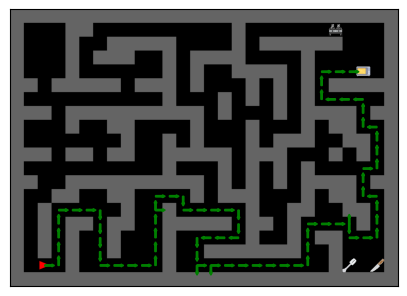

In [11]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

# Universal Successor Feature Approximators

In [12]:
from housemaze.human_dyna import sf_task_runner

task_runner_sf = sf_task_runner.TaskRunner(
    task_objects=housemaze_analysis.task_objects,
    vis_coeff=0.1,
    radius=5)
sf_env = maze.HouseMaze(
    task_runner=task_runner_sf,
    num_categories=200,
)
sf_env = utils.AutoResetWrapper(sf_env)


exp = 'exp2'
paths = f'{data_dir}/model_data/{download_data.sf_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='usfa',
        make_fns=functools.partial(
            housemaze_trainer.get_sf_fns,
            env=sf_env,
            env_params=dummy_env_params),
        env=sf_env,
        example_env_params=dummy_env_params,
        nenvs=nenvs,
        config=dict(EVAL_TASK_SUPPORT='train')
    )
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed),
        data_task_runner=task_runner_sf,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)
    

  0%|          | 0/1 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_39489/2620379054.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  def first(eps): return jax.tree_map(lambda x:x[0], eps)


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""usfa""","""exp2""",0,26,"""big_m1_maze3""",1
true,"""usfa""","""exp2""",0,40,"""big_m1_maze3""",1
false,"""usfa""","""exp2""",0,26,"""big_m2_maze2""",1
true,"""usfa""","""exp2""",0,40,"""big_m2_maze2""",1
false,"""usfa""","""exp2""",0,26,"""big_m3_maze1""",1


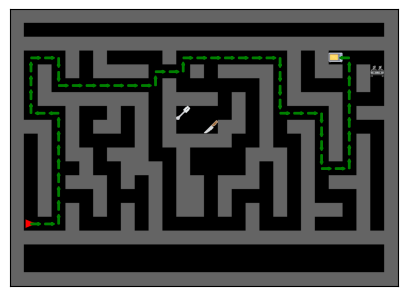

In [13]:
def first(eps): return jax.tree_map(lambda x:x[0], eps)
housemaze_analysis.render_path(first(episodes[0]))
df.head()

### Dyna-Q

In [14]:
exp = 'exp2'
# dyna_dir = f'ql/save_data/ql-21/exp={exp}'
dyna_dir = download_data.dyna_dir
paths = f'{data_dir}/model_data/{dyna_dir}/*'
paths = glob(paths)

for path in tqdm(paths):
    seed = path.split('/')[-1].split("=")[-1]
    algorithm = data_loading.load_algorithm(
        path=path,
        name='dynaq_shared',
        make_fns=functools.partial(housemaze_trainer.get_dynaq_fns,
            env=env,
            env_params=dummy_env_params,
            task_objects=housemaze_analysis.task_objects),
        env=env,
        example_env_params=dummy_env_params,
        nenvs=nenvs)
    df, episodes = housemaze_analysis.get_algorithm_data(
        algorithm=algorithm,
        exp=exp,
        overwrite=False,
        extra_info=dict(seed=seed)
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)



  0%|          | 0/2 [00:00<?, ?it/s]

No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_39489/2620379054.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  def first(eps): return jax.tree_map(lambda x:x[0], eps)


eval,algo,exp,room,task,maze_name,seed
bool,str,str,i64,i64,str,i64
false,"""dynaq_shared""","""exp2""",0,26,"""big_m3_maze1""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m3_maze1""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m2_maze2_onpath""",2
true,"""dynaq_shared""","""exp2""",0,40,"""big_m2_maze2_onpath""",2
false,"""dynaq_shared""","""exp2""",0,26,"""big_m2_maze2_offpath""",2


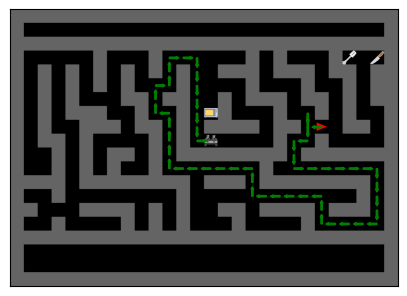

In [15]:
housemaze_analysis.render_path(first(episodes[-1]))
df.head()

### BFS/DFS

In [16]:
for algorithm in ['bfs', 'dfs']:
    df, episodes = housemaze_analysis.get_search_data(
        algorithm=algorithm,
        env=env,
        exp='exp2',
        base_path=f'{data_dir}/search_algos',
        budget=None,
        overwrite=False,
        searches=10,
      )
    model_df_list.append(df)
    model_episodes_list.extend(episodes)

No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy
No file specified for groups.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/human_dyna/list_of_groups.npy


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_39489/2620379054.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  def first(eps): return jax.tree_map(lambda x:x[0], eps)


eval,algo,exp,room,task,budget,maze_name
bool,str,str,i64,i64,str,str
false,"""dfs""","""exp2""",0,26,null,"""big_m1_maze3"""
true,"""dfs""","""exp2""",0,40,null,"""big_m1_maze3"""
false,"""dfs""","""exp2""",0,26,null,"""big_m2_maze2"""
true,"""dfs""","""exp2""",0,40,null,"""big_m2_maze2"""
false,"""dfs""","""exp2""",0,26,null,"""big_m3_maze1"""


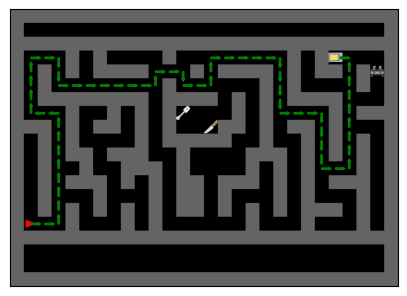

In [17]:
housemaze_analysis.render_path(first(episodes[0]))
df.head()

## put all model things together now

In [18]:
model_df = (
    pl.concat(model_df_list, how="diagonal_relaxed")
    .with_row_count(name="row_number")
    .with_columns(
        pl.col("row_number").alias("index")
    )
    .drop("row_number")
)
model_df = dataframe.DataFrame(
    df=model_df,
    episodes=model_episodes_list,
)
model_df.head()

/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_39489/1099679968.py:2: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  pl.concat(model_df_list, how="diagonal_relaxed")


index,eval,algo,exp,room,task,maze_name,seed,budget
u32,bool,str,str,i64,i64,str,i64,str
0,false,"""qlearning""","""exp2""",0,26,"""big_m3_maze1""",1,null
1,true,"""qlearning""","""exp2""",0,40,"""big_m3_maze1""",1,null
2,false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_onpath""",1,null
3,true,"""qlearning""","""exp2""",0,40,"""big_m2_maze2_onpath""",1,null
4,false,"""qlearning""","""exp2""",0,26,"""big_m2_maze2_offpath""",1,null


# Human data

In [184]:
from analysis import data_loading
from analysis.download_data import download_user_files

bucket_name = "human-dyna"
prefix = "data/"
#pattern = "data/data_user=*_name=r0-v2*debug=0.json"
human_data_pattern = "data/data_user=*exp3*v2*debug=0.json"
destination_folder = "/Users/wilka/git/research/results/human_dyna/user_data/exp3"

download_user_files(bucket_name, prefix, human_data_pattern, destination_folder)

Downloaded: data/data_user=1222909386_name=exp3-v2-r1-t30_exp=3_debug=0.json to /Users/wilka/git/research/results/human_dyna/user_data/exp3/data_user=1222909386_name=exp3-v2-r1-t30_exp=3_debug=0.json
Downloaded: data/data_user=1265155292_name=exp3-v2-r1-t30_exp=3_debug=0.json to /Users/wilka/git/research/results/human_dyna/user_data/exp3/data_user=1265155292_name=exp3-v2-r1-t30_exp=3_debug=0.json
Downloaded: data/data_user=1628406922_name=exp3-v2-r1-t30_exp=3_debug=0.json to /Users/wilka/git/research/results/human_dyna/user_data/exp3/data_user=1628406922_name=exp3-v2-r1-t30_exp=3_debug=0.json
Downloaded: data/data_user=1807170453_name=exp3-v2-r1-t30_exp=3_debug=0.json to /Users/wilka/git/research/results/human_dyna/user_data/exp3/data_user=1807170453_name=exp3-v2-r1-t30_exp=3_debug=0.json
Downloaded: data/data_user=1995466486_name=exp3-v2-r1-t30_exp=3_debug=0.json to /Users/wilka/git/research/results/human_dyna/user_data/exp3/data_user=1995466486_name=exp3-v2-r1-t30_exp=3_debug=0.json


In [185]:
data_dir = '/Users/wilka/git/research/results/human_dyna/'
files = f'{data_dir}/user_data/*exp3*/*exp3*v2*.json'
user_base_path = f'{data_dir}/user_data'
files = glob(files)
files, len(files)

22

In [186]:
web_env = SuccessTrackingAutoResetWrapper(base_env)
example_web_timestep = web_env.reset(dummy_rng, dummy_env_params)

In [24]:
# # TESTING
# import json
# file = files[1]
# with open(file, 'r') as f:
#     try:
#         data = json.load(f)
#     except Exception as e:
#         print('-'*25)
#         print(os.path.basename(file))
#         print(e)
# data_loading.make_episode_data(data=data, example_timestep=example_web_timestep, file=file)

In [188]:
# %debug 
user_df = data_loading.make_all_episode_data(
    files=files,
    example_timestep=example_web_timestep,
    overwrite=False,
    # debug=True
)
user_df.head()

No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
Filtered 38 data points


Processing episodes:   0%|          | 0/116 [00:00<?, ?it/s]

No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
Filtered 74 data points


Processing episodes:   0%|          | 0/75 [00:00<?, ?it/s]]

No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
Filtered 47 data points


Processing episodes:  88%|████████▊ | 66/75 [04:57<00:37,  4.21s/it]]

No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl
No file specified for image dict.
Using: /Users/wilka/git/research/human-dyna-web/libraries/housemaze/housemaze/image_data.pkl


Processing episodes: 100%|██████████| 109/109 [07:00<00:00,  3.86s/it]


index,maze,condition,name,block,manipulation,episode_idx,eval,task,room,user_id,age,sex,exp,new_path,old_path
u32,str,i64,str,str,i64,i64,bool,i64,i64,i64,i64,str,str,bool,bool
0,"""big_m2_maze2""",0,"""big_m2_maze2""","""faster when on-path but furthe…",2,1,false,3,0,3712207029,53,"""Male""","""exp3-v2-r1-t30""",null,null
1,"""big_m2_maze2""",0,"""big_m2_maze2""","""faster when on-path but furthe…",2,2,false,3,0,3712207029,53,"""Male""","""exp3-v2-r1-t30""",null,null
2,"""big_m2_maze2""",0,"""big_m2_maze2""","""faster when on-path but furthe…",2,3,false,29,1,3712207029,53,"""Male""","""exp3-v2-r1-t30""",null,null
3,"""big_m2_maze2""",0,"""big_m2_maze2""","""faster when on-path but furthe…",2,4,false,29,1,3712207029,53,"""Male""","""exp3-v2-r1-t30""",null,null
4,"""big_m2_maze2""",0,"""big_m2_maze2""","""faster when on-path but furthe…",2,5,false,3,0,3712207029,53,"""Male""","""exp3-v2-r1-t30""",null,null


In [206]:
user_df['exp'].unique()

exp
str
"""exp3-v2-r1-t30"""


# Eval statistics

In [27]:
from IPython.display import Markdown, display
from analysis import housemaze
from analysis import plots
from analysis.plots import split_filter_fn, success_or_not_terminate, success

## Paths manipulation (3)

In [157]:
# plots.m3_reaction_times(user_df, episode_selection='longest')

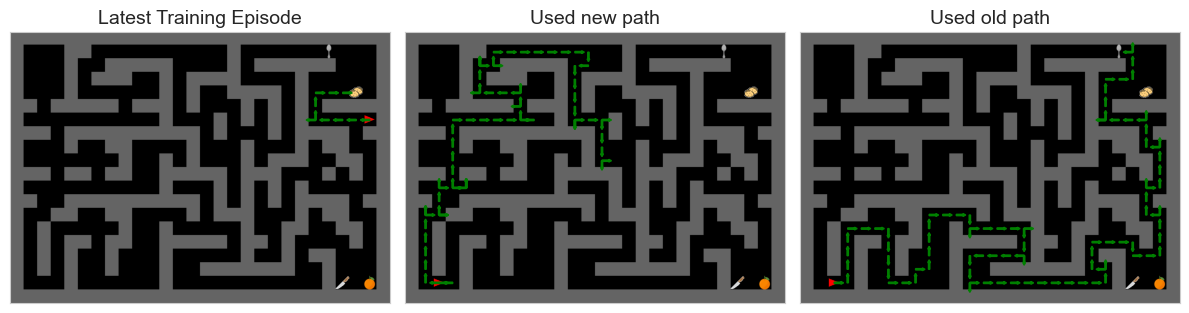

/Users/wilka/git/research/human-dyna-web/analysis/plots.py:1325: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  # Set up the plot style
/Users/wilka/git/research/human-dyna-web/analysis/plots.py:1325: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  # Set up the plot style


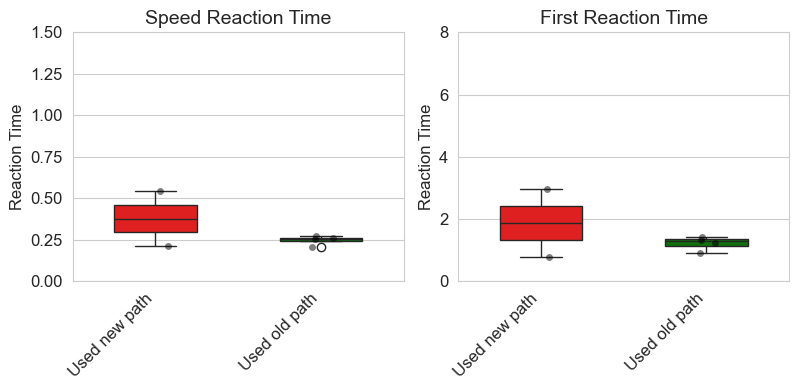

In [162]:
plots.m3_reaction_times(user_df, episode_selection='latest', ylim=[[0, 1.5], [0, 8]])

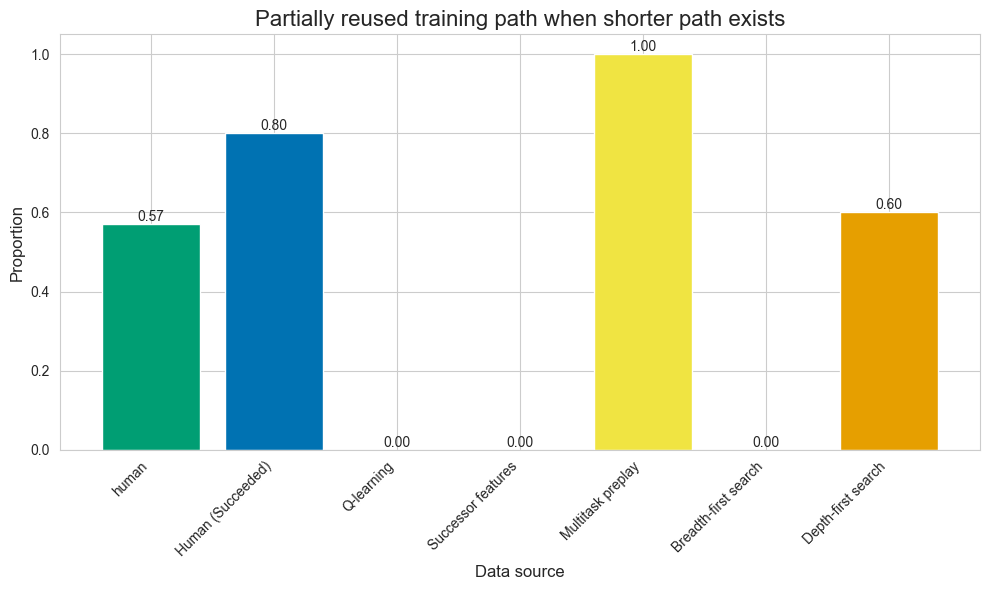

In [158]:
plots.create_bar_plot_results_m3(user_df, model_df)

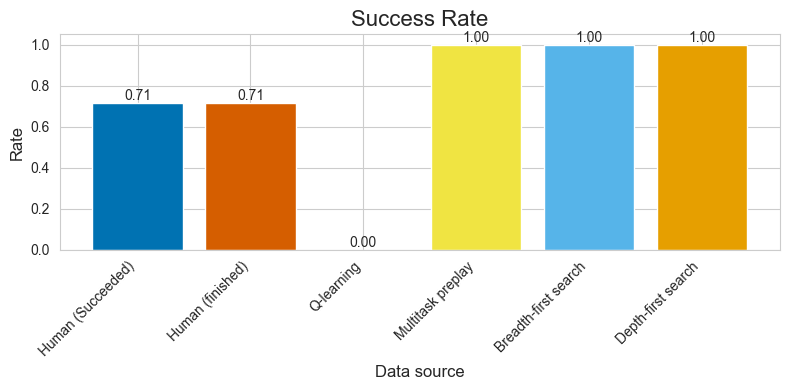

In [189]:
# %debug
plots.create_success_termination_results_m3(user_df, model_df)

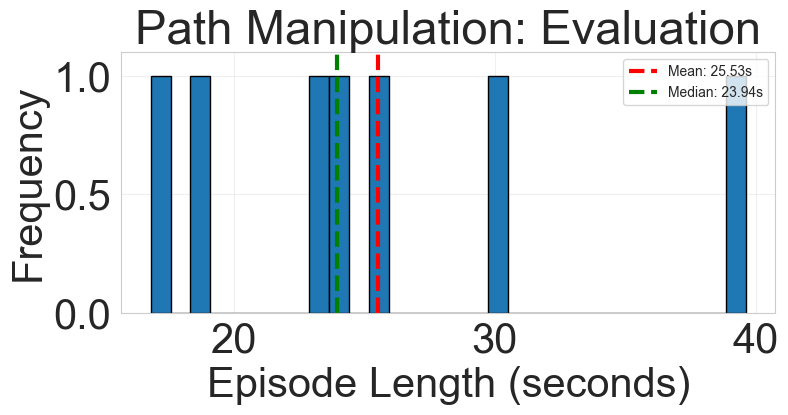

In [190]:
plots.plot_episode_length_seconds(
    user_df,
    stages=['big_m3_maze1_eval'],
    settings=dict(eval=True), title_size=34, label_size=30)

In [191]:
display(Markdown("""
### epidoes where people take longer than 30 sconds
"""))


### epidoes where people take longer than 30 sconds


In [192]:
 
manipulation = 3

subset = user_df.subset(
    filter_fn=plots.split_filter_fn,
    output_filter_fn=lambda e: sum(e.reaction_times[:-1]/1000.) < 30,
    filter_settings=dict(eval=False),
    output_settings=dict(manipulation=manipulation, eval=True),
)

In [96]:
for i, e in enumerate(subset.episodes):
 print(i, e.reaction_times[:-1].sum()/1000)

0 39.611


In [205]:
# housemaze.create_episode_reaction_times_video(subset.episodes[0])

## Starting point manipulation (2)

Skipping 3712207029
Skipping 3712207029


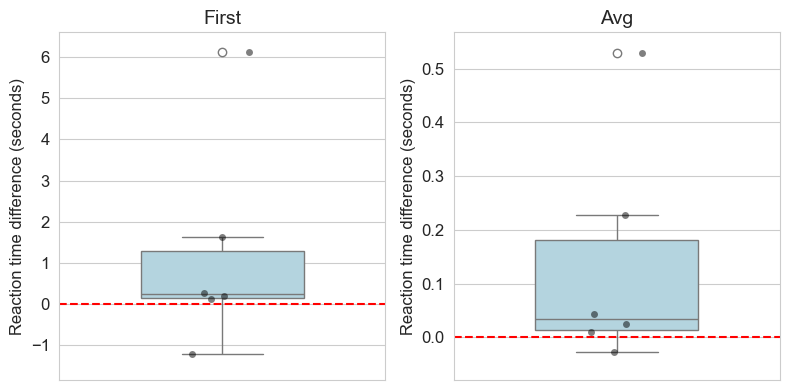

In [183]:
plots.m2_reaction_time_difference(user_df, ['first', 'avg'])


### time(off-path) - time(on-path)
The RT when you're on oath should be smaller than off-path. Want this to be positive.


Skipping 3712207029


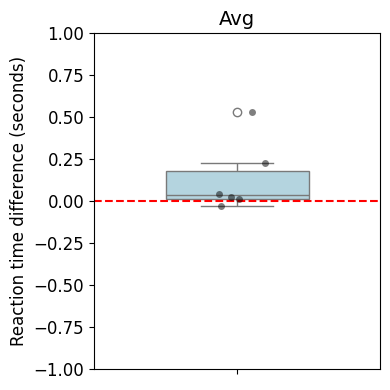

In [152]:
display(Markdown("""
### time(off-path) - time(on-path)
The RT when you're on oath should be smaller than off-path. Want this to be positive.
"""))
# plots.m2_reaction_time_difference(user_df, ['first'], y_lim=[-2, 7])
plots.m2_reaction_time_difference(user_df, ['avg'], y_lim=[-1, 1])

## Planning manipulation (4) - short

In [153]:
# plots.plot_m4_example(user_df, 'short')

In [165]:
# plots.m4_reaction_time_difference(user_df, setting='short', rt_types=['first', 'avg'])

removed: user 439238735 rate: 0.4444444477558136 = 8/18
removed: user 722314323 rate: 0.4000000059604645 = 8/20
removed: user 738730044 rate: 0.09677419066429138 = 3/31
Skipping 2071777466


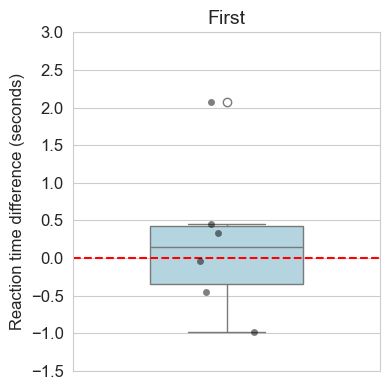

In [203]:
plots.m4_reaction_time_difference(user_df, setting='short', rt_types=['first'], ylim=[-1.5, 3])

removed: user 439238735 rate: 0.4444444477558136 = 8/18
removed: user 722314323 rate: 0.4000000059604645 = 8/20
removed: user 738730044 rate: 0.09677419066429138 = 3/31


/Users/wilka/git/research/human-dyna-web/analysis/plots.py:666: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  
/Users/wilka/git/research/human-dyna-web/analysis/plots.py:666: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


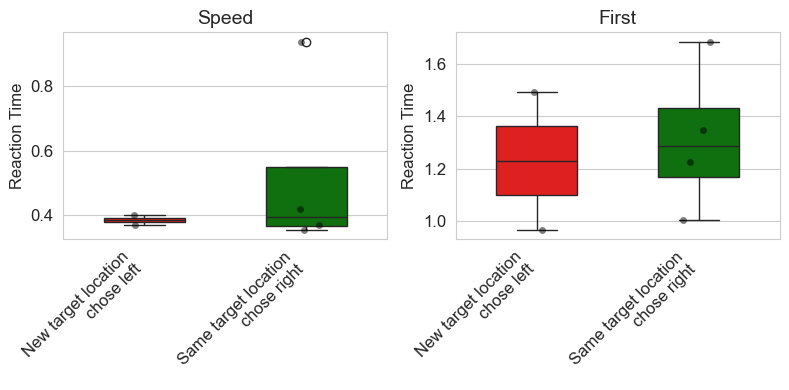

In [204]:
plots.m4_action_reaction_time_difference(user_df, setting='short')

removed: user 439238735 rate: 0.4444444477558136 = 8/18
removed: user 722314323 rate: 0.4000000059604645 = 8/20
removed: user 738730044 rate: 0.09677419066429138 = 3/31


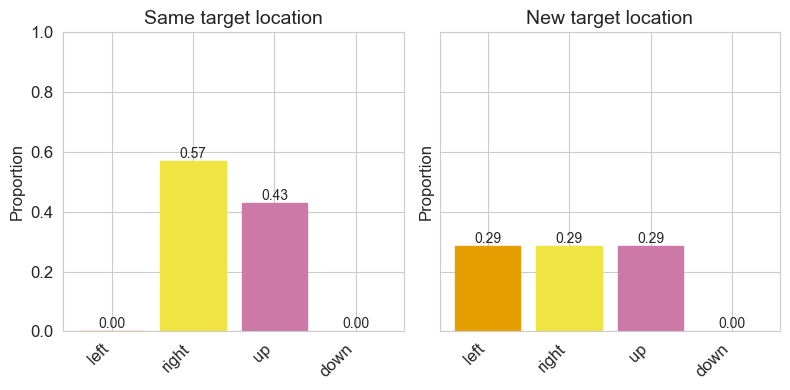

In [191]:
plots.m4_initial_action_distribution(user_df, setting='short')

removed: user 439238735 rate: 0.4444444477558136 = 8/18
removed: user 722314323 rate: 0.4000000059604645 = 8/20
removed: user 738730044 rate: 0.09677419066429138 = 3/31


/Users/wilka/git/research/human-dyna-web/analysis/plots.py:666: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  
/Users/wilka/git/research/human-dyna-web/analysis/plots.py:666: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


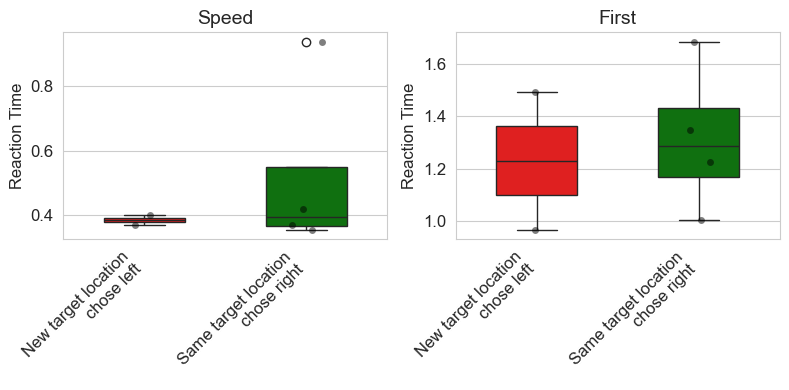

In [200]:
plots.m4_action_reaction_time_difference(user_df, setting='short')
# plots.m4_initial_action_distribution(user_df, 'short')
# plots.m4_reaction_times(user_df, 'short', 'first', ylim=[0,4])
# plots.m4_reaction_times(user_df, 'short', 'speed')

In [143]:
# plots.m4_action_reaction_times_difference(user_df, 'short', 'first')

In [144]:
# plots.m4_action_reaction_times_difference(user_df, 'short', 'speed')

In [171]:
# plots.plot_path_lengths_m4(user_df, 'short')

In [147]:
# plots.plot_episode_lengths_m4(user_df, 'short')

In [137]:
# plots.plot_episode_lengths_m4(user_df, 'short')

## Planning manipulation (4) - long

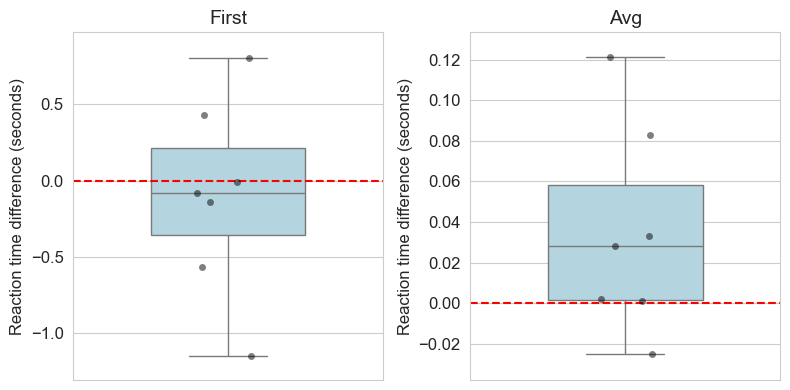

In [172]:
plots.m4_reaction_time_difference(user_df, setting='long', rt_types=['first', 'avg'])

removed: user 722314323 rate: 0.4000000059604645 = 8/20


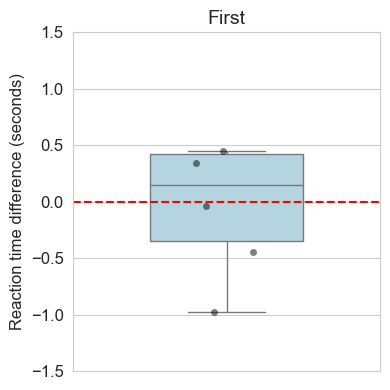

In [173]:
plots.m4_reaction_time_difference(user_df, setting='short', rt_types=['first'], y_lim=[-1.5, 1.5])

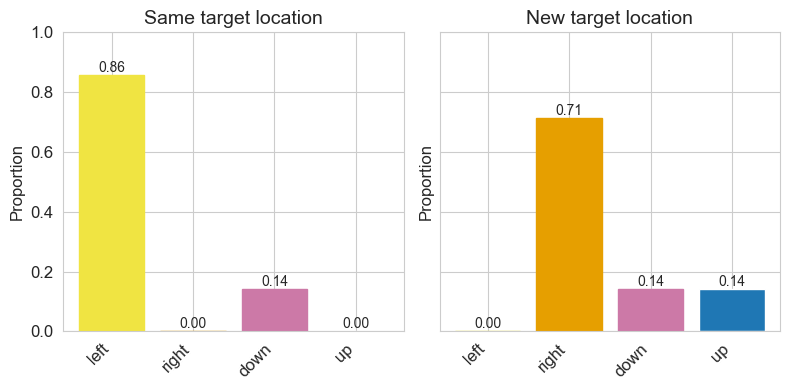

In [174]:
plots.m4_initial_action_distribution(user_df, setting='long')

/Users/wilka/git/research/human-dyna-web/analysis/plots.py:1150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_rt_by_action(axs[0], cond2.episodes, 'Same target location')
/Users/wilka/git/research/human-dyna-web/analysis/plots.py:1150: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_rt_by_action(axs[0], cond2.episodes, 'Same target location')


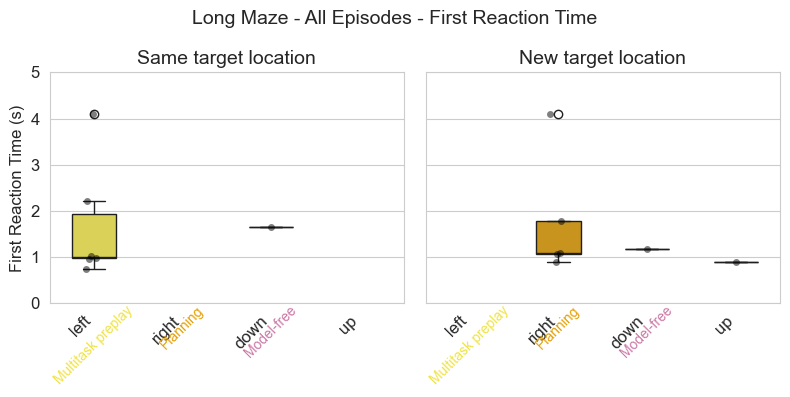

In [177]:
plots.m4_reaction_times(user_df, 'long', 'first', ylim=[0,5])


# Training statistics

In [178]:
# plots.plot_train_reaction_times_dual(user_df)

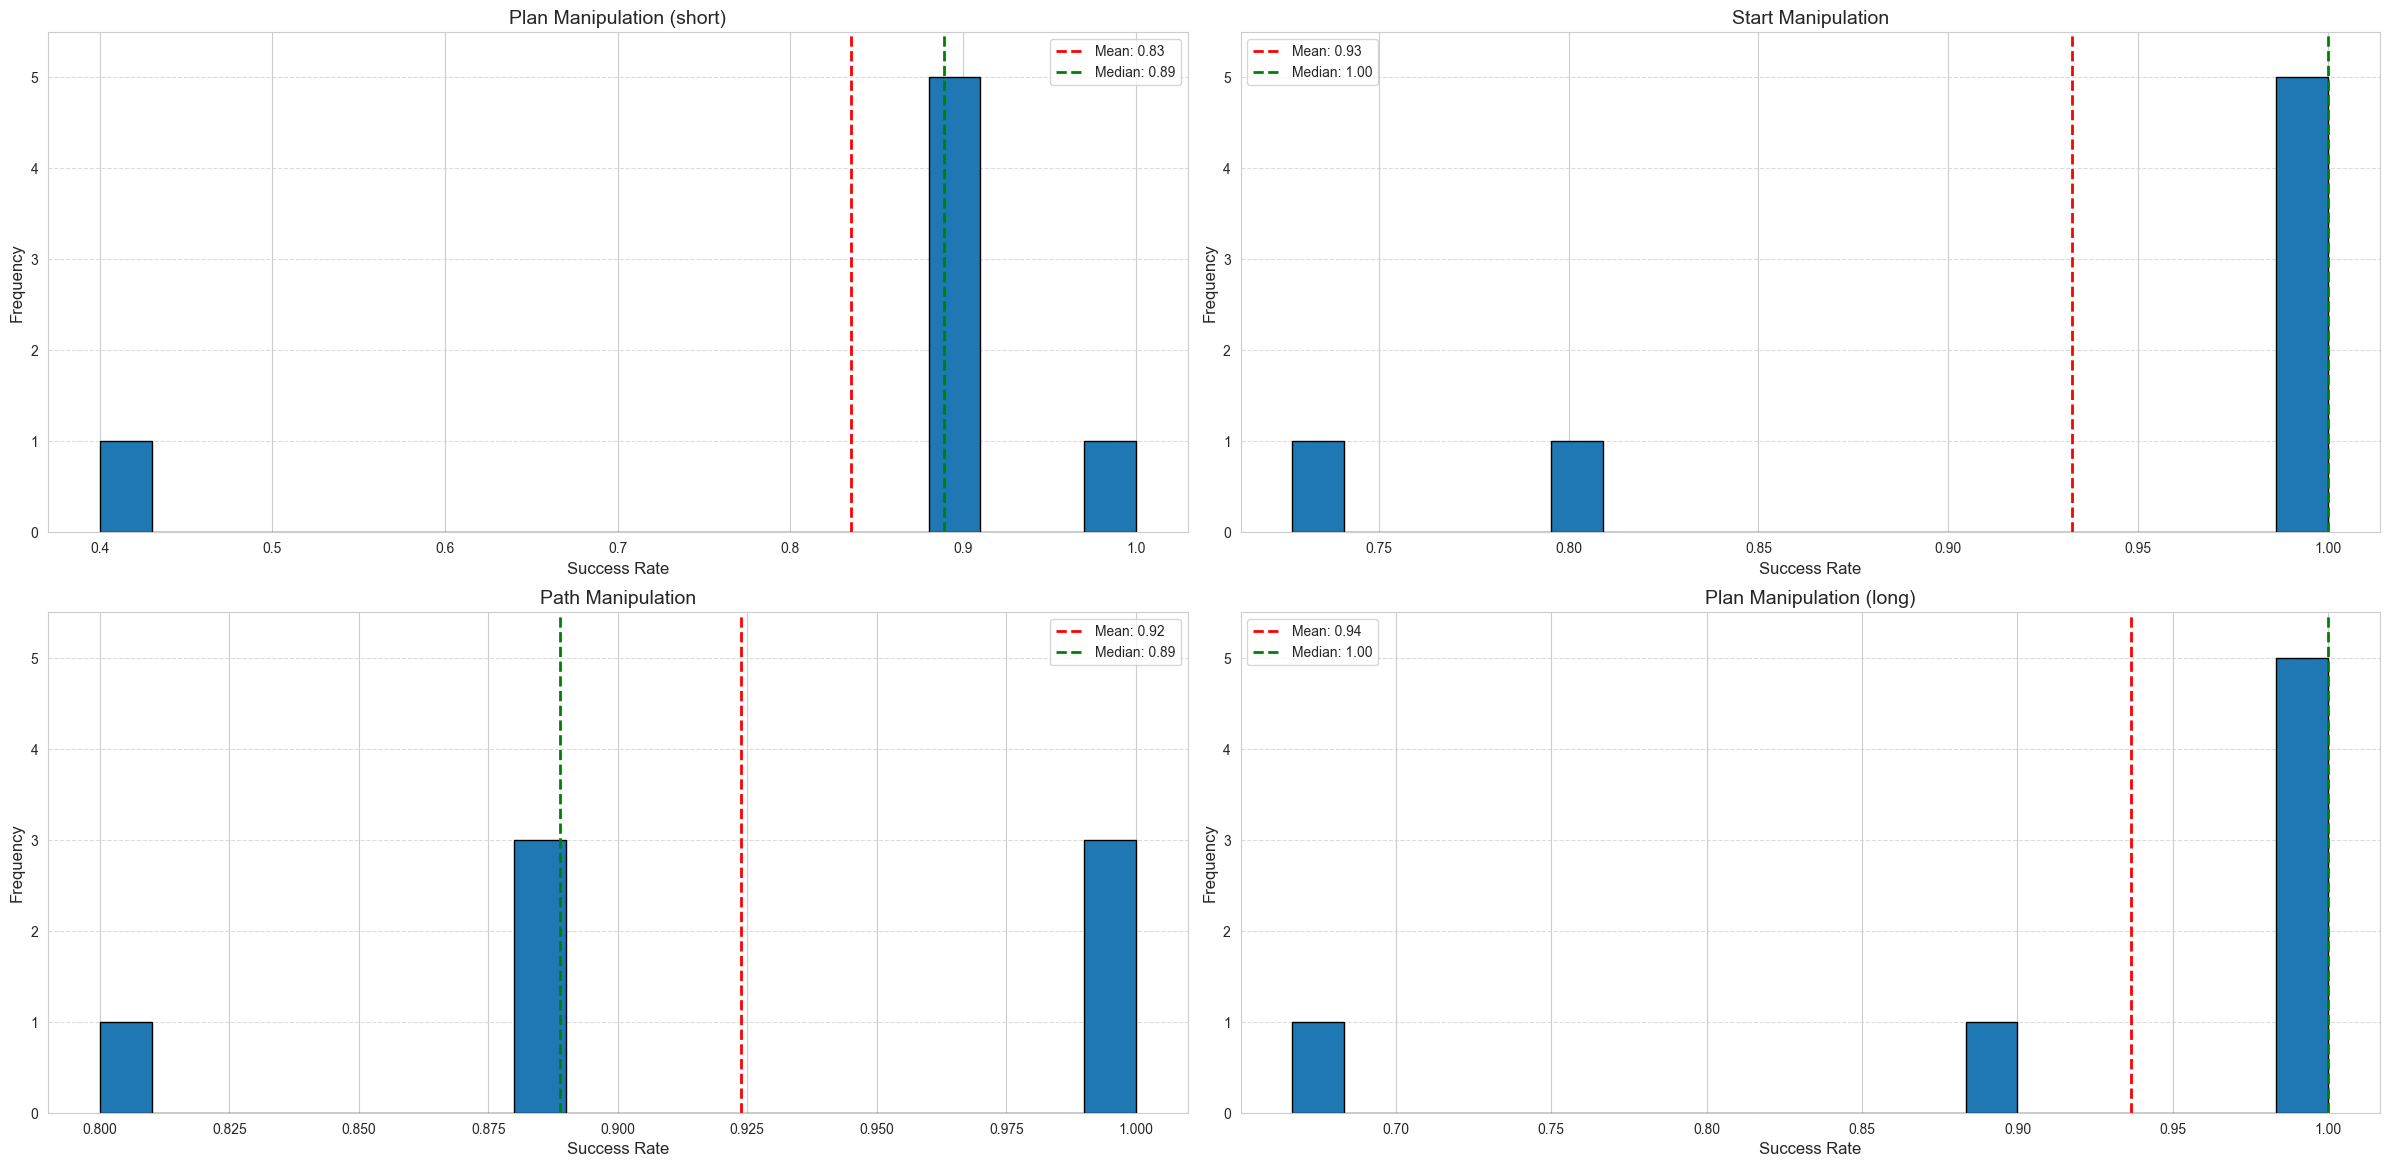

In [179]:
plots.plot_train_success_rate_histograms(user_df)

In [180]:
# plots.plot_episode_counts(user_df)

In [181]:
# plots.plot_episode_length_seconds(user_df, title_size=34, label_size=30)